# MBM40

## Packages

In [11]:
from typing import Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numpy import ndarray

from astropy.io import fits
from astropy.io.fits import HDUList
import astropy.units as u

from spectral_cube import SpectralCube, Slice

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp


## Functions and Stuff

### For data

In [12]:
import os

class PathVar():
    
    @staticmethod
    def this_dir() -> str:
        return os.getcwd()

    def __init__(self, path: str = '') -> None:
        self.PATH = path  if path != '' else PathVar.this_dir()

    def split(self) -> list[str]:
        if self.PATH[0] == os.sep:
            return [os.sep] + self.PATH.split(os.sep)
        else:
            return self.PATH.split(os.sep)
        

    def copy(self) -> 'PathVar':
        return PathVar(self.PATH)

    def __add__(self, path: str) -> 'PathVar':
        new_path = os.path.join(self.PATH,path)
        return PathVar(path=new_path)
     
    def __sub__(self, up: int) -> 'PathVar':
        path_list = self.split()
        new_path = os.path.join(*path_list[:-up])
        return PathVar(path=new_path)
    
    def __str__(self) -> str:
        return self.PATH 
     

class FileVar(PathVar):

    def __init__(self, filename: str | list[str], dirpath: str | PathVar = '') -> None:
        self.DIR  = dirpath if isinstance(dirpath, PathVar) else PathVar(path = dirpath)
        self.FILE = filename

    def path(self) -> str | list[str]:
        filename = self.FILE 
        dirname = self.DIR.copy()
        if isinstance(filename,str): 
            return (dirname + filename).PATH
        else:
            return [(dirname + name).PATH for name in filename]

    def __getitem__(self,item: int) -> str:
        path = self.path()
        if isinstance(path,str): return TypeError('Variable is not subscriptable')
        else: return path[item]
    
    def __setitem__(self,key:int,item:str) -> None:
        if isinstance(self.FILE,str): 
            return TypeError('Variable is not subscriptable')
        else: 
            self.FILE[key] = item


    def __str__(self) -> str:
        return str(self.path())


PROJECT_DIR = PathVar()

### For fits files

In [13]:
def hotpx_remove(data: ndarray) -> ndarray:
    """To remove hot pixels from the image

    Parameters
    ----------
    data : ndarray
        spectrum data

    Returns
    -------
    data : ndarrayfrom astropy

    Notes
    -----
    The function replacing `NaN` values from the image, if there are.
    I did not implement this function, I took it from [*astropy documentation*](https://docs.astropy.org/en/stable/convolution/index.html)

    """
    from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
    # check the presence of `NaNs`
    if True in np.isnan(data):
        # build a gaussian kernel for the interpolation
        kernel = Gaussian2DKernel(x_stddev=1)
        # remove the `NaNs`
        data = interpolate_replace_nans(data, kernel)
    return data



def showfits(data: np.ndarray, v: int = -1, title: str = '', n: int = None, norm: str ='linear', dim: list[int] = [10,7], labels: tuple[str,str] = ('',''), ticks: tuple[ndarray[float] | None, ndarray[float] | None] = (None,None), tickslabel: tuple[ ndarray[str | float] | None,  ndarray[str | float] | None] = (None, None),**kwimg) -> None:
    """Function to display the fits image.
    filename
    You can display simply the image or set a figure number and a title.

    :param data: image matrix of fits file
    :type data: np.ndarray
    :param v: cmap parameter: 1 for false colors, 0 for grayscale, -1 for reversed grayscale; defaults to -1
    :type v: int, optional
    :param title: title of the image, defaults to ''
    :type title: str, optional
    :param n: figure number, defaults to None
    :type n: int, optional
    :param dim: figure size, defaults to [10,7]
    :type dim: list[int], optional
    """
    plt.figure(n,figsize=dim)
    plt.title(title)
    if v == 1 : color = 'viridis'
    elif v == 0 : color = 'gray'
    else : color = 'gray_r'
    plt.imshow(data, cmap=color, norm=norm, origin='lower',**kwimg)
    plt.colorbar()
    # plt.xlabel(labels[0])
    # plt.ylabel(labels[1])
    # if_stat = lambda tck : tck[0] is None and tck[1] is None  
    # if if_stat(ticks) and not if_stat(tickslabel):
    #     ticks = (np.arange(*tickslabel[0].shape), np.arange(*tickslabel[1].shape))     
    # plt.xticks(ticks[0],tickslabel[0])
    # plt.yticks(ticks[1],tickslabel[1])


def get_data_fit(path: str, lims: list[int | None] = [None,None,None,None], v: int = -1, title: str = '', n: int = None, dim: list[int] = [10,7], hotpx: bool = True, display_plots: bool = True, **imgargs) -> tuple[HDUList, ndarray]:
    """Function to open fits file and extract data.
    
    It brings the path and extracts the data, giving a row image.
    
    You can set a portion of image and also the correction for hotpx.

    It calls the functions: 
      - `hotpx_remove()`
      - `showfits()`

    :param path: path of the fits file
    :type path: str
    :param lims: edges of the fits, defaults to [None,None,None,None]
    :type lims: list[int | None], optional
    :param hotpx: parameter to remove or not the hot pixels, defaults to True
    :type hotpx: bool, optional
    :param v: cmap parameter: 1 for false colors, 0 for grayscale, -1 for reversed grayscale; defaults to -1
    :type v: int, optional
    :param title: title of the image, defaults to ''
    :type title: str, optional
    :param n: figure number, defaults to None
    :type n: int, optional
    :param dim: figure size, defaults to [10,7]
    :type dim: list[int], optional

    :return: `hdul` list of the chosen fits file and `data` of the spectrum
    :rtype: tuple

    .. note:: `lims` parameter controls the x and y extremes in such the form [lower y, higher y, lower x, higher x]
    """
    # open the file
    hdul = fits.open(path)
    # print fits info
    hdul.info()
    # print header
    hdr = hdul[0].header
    print(' - HEADER -')
    print(hdr.tostring(sep='\n'))
    print()

    # data extraction
    # format -> data[Y,X]
    data = hotpx_remove(hdul[0].data) if hotpx else hdul[0].data
    ly,ry,lx,rx = lims
    data = data[ly:ry,lx:rx]
    # hot px correction
    # Spectrum image
    if display_plots == True: showfits(data, v=v,title=title,n=n,dim=dim, **imgargs) 
    return hdul,data


### For Cubes

In [14]:
u_vel = u.km / u.s
u.add_enabled_units(u.def_unit(['K (Tb)'], represents=u.K))


def select_channel(cube: SpectralCube, vel_val: float) -> Slice:
    ch_pos = np.argmin(np.abs(cube.with_spectral_unit(u_vel).spectral_axis - vel_val*u_vel))
    return cube[ch_pos, : , :]



## Load data


In [16]:
from pandas import read_csv
MBM40_DIR = PROJECT_DIR + 'MBM40'
DATA_FILE = FileVar(filename='data.csv',dirpath=MBM40_DIR)
co_files, hi_files, ir_files = read_csv(DATA_FILE.path()).to_numpy().transpose()
co_paths = FileVar(co_files,MBM40_DIR+'CO')
hi_paths = FileVar(hi_files,MBM40_DIR+'HI')
ir_paths = FileVar(ir_files,MBM40_DIR+'IR')
print(co_paths)
print(hi_paths)
print(ir_paths)

['/home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/CO/MBM40_FCRAO_CO_CLEANED_upheader.fits', '/home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/CO/MBM40_12CO_xdr.fits', "/home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/CO/''"]
['/home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/HI/GALFA_HI_RA+DEC_244.00+18.35_W.fits', '/home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/HI/GALFA_HI_RA+DEC_244.00+26.35_W.fits', '/home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/HI/GALFA_HI_sticked.fits']
['/home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/IR/IRAS-60_RA+DEC_242.64+21.822.fits', '/home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/IR/IRAS-100_RA+DEC_242.64+21.8

## CO 

  - 0 : `'MBM40_FCRAO_CO_CLEANED_upheader.fits'`
  - 1 : `'MBM40_12CO_xdr.fits'`

In [24]:
co_cube : SpectralCube = SpectralCube.read(co_paths[0]).with_spectral_unit(u_vel)

vel, dec, ra = co_cube.world[:]

ra  =  ra[0,0,:].value
dec = dec[0,:,0].value
vel = vel[:,0,0].value

print(co_cube.header.tostring(sep='\n'))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  130                                                  
NAXIS2  =                  160                                                  
NAXIS3  =                   56                                                  
OBJECT  = 'FCRAO MBM40 CO cleaned map' / Object Name                            
BUNIT   = 'K       '           / Units of pixel data values                     
OBSERVER= 'FCRAO : Five College Radio Astronomy Observatory'                    
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 66.5 / Pixel coordinate of reference point            
CRPIX2  =                 81.5 / Pixel coordinate of reference point            
CRPIX3  =                 29

(160, 130)


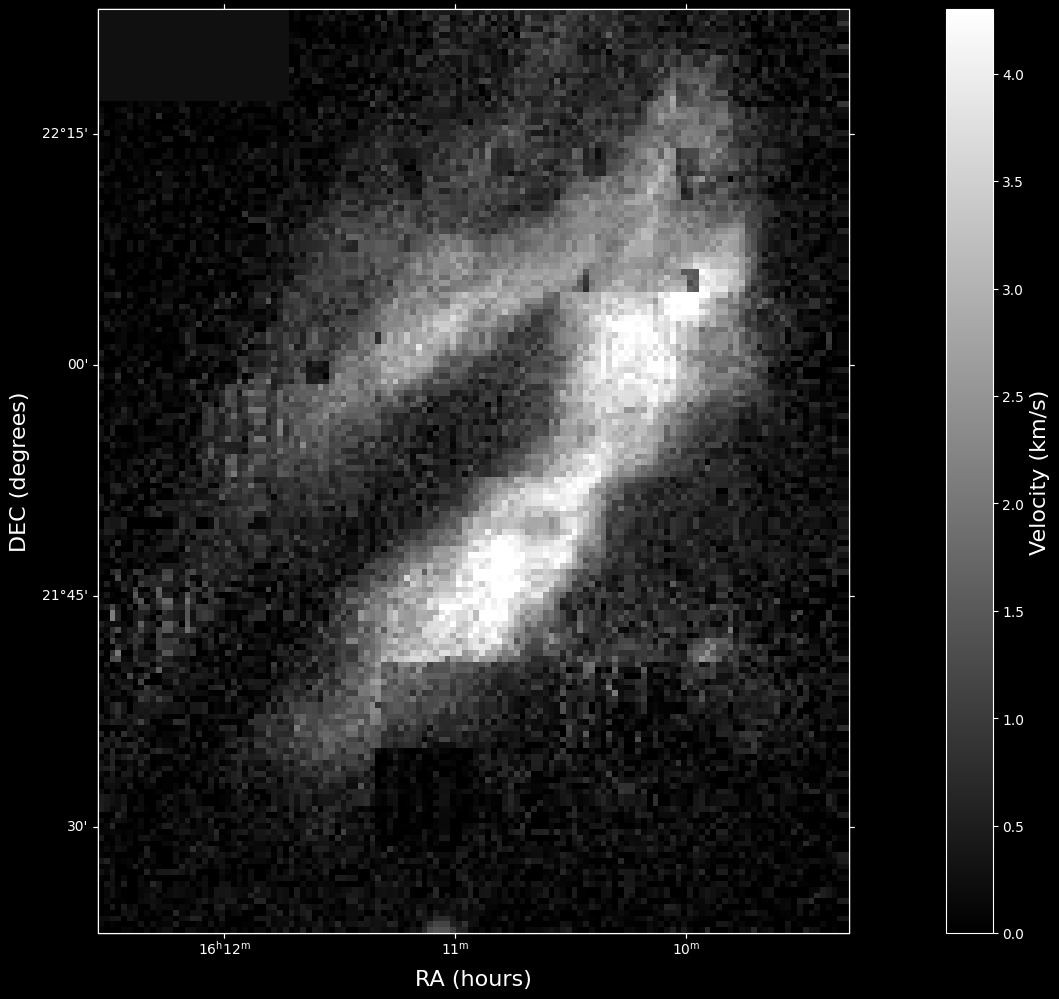

In [27]:

co_m0 = co_cube.moment0()
co_m1 = co_cube.moment1()

print(co_m0.hdu.data.shape)

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=co_m0.wcs)

# Display the moment map image
im = ax.imshow(co_m0.hdu.data, cmap='gray', origin='lower', vmin=0, vmax=vel[-1])


# Add axes labels
ax.set_xlabel("RA (hours)", fontsize=16)
ax.set_ylabel("DEC (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

plt.show()

## 60-100 micron

Data files:

 - 0 : `IRAS-60_RA+DEC_242.64+21.822.fits`
 - 1 : `IRAS-100_RA+DEC_242.64+21.822.fits`

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/filaments_strc_param/MBM40/IR/IRAS-60_RA+DEC_242.64+21.822.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     133   (1000, 1000)   float32   
 - HEADER -
SIMPLE  =                    T / Written by SkyView Thu Oct 17 10:19:07 EDT 2024
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                 1000 / Width of image                                 
NAXIS2  =                 1000 / Height of image                                
CRVAL1  =   242.64199999999994 / Reference longitude                            
CRVAL2  =               21.822 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                  

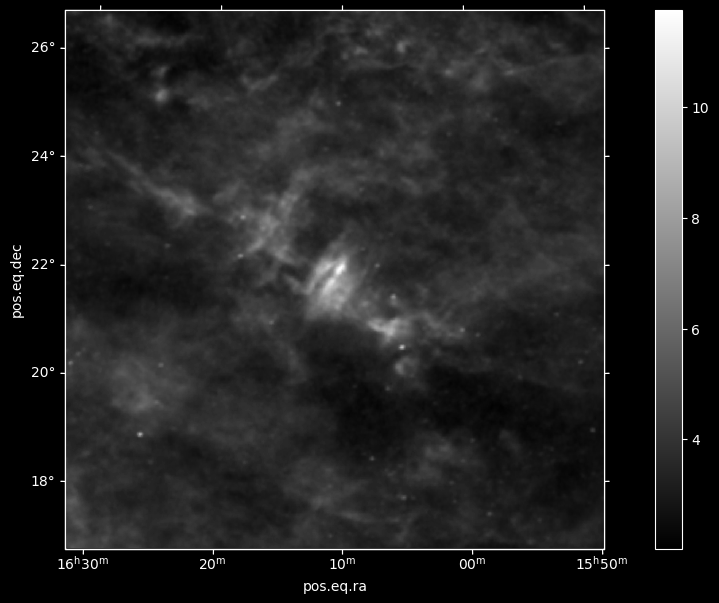

In [23]:
ir60_hdul, ir60_data   = get_data_fit(ir_paths[0],display_plots=False) 
ir100_hdul, ir100_data = get_data_fit(ir_paths[1],display_plots=False) 

ir100_wcs = WCS(ir100_hdul[0].header)

fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=ir100_wcs)
ir_img = ax.imshow(ir100_data,cmap='gray')
plt.colorbar(ir_img)
plt.show()

In [ ]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=hi_m01.wcs)

img_hi = ax.imshow(hi_m01.hdu.data,cmap='viridis',origin='lower')
cbar_hi = plt.colorbar(img_hi, fraction=0.046)
cbar_hi.set_label('Intensity [K km/s]')
ir_transform = ax.get_transform(ir100_wcs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
levels = (5,6,7,8,9,10,11,12)
img_ir = ax.contour(ir100_data,cmap='gray',levels=levels,transform=ir_transform)
# cbar_hi = plt.colorbar(img_co, orientation='horizontal',  fraction=0.046, pad=0.07)
# cbar_hi.set_label('Intensity [K km/s]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

## HI 21cm

  - 0 : `'GALFA_HI_RA+DEC_244.00+18.35_W.fits'`
  - 1 : `'GALFA_HI_RA+DEC_244.00+26.35_W.fits'`


### Narrow Window

In [ ]:
vel_range = (vel[0]*u_vel, vel[-1]*u_vel)
ra_range  = (243.5*u.deg,242*u.deg)
dec_range = (21*u.deg,22.608326*u.deg)

channel = 3.4


In [ ]:
cube1 : SpectralCube = SpectralCube.read(hi_paths[0]).with_spectral_unit(u_vel).subcube(*ra_range,*dec_range,*vel_range)
print(cube1)
cube1_slice = select_channel(cube1,channel)

del cube1

In [ ]:

dec_range = (22.608326*u.deg,23*u.deg)
cube2 : SpectralCube = SpectralCube.read(hi_paths[1]).with_spectral_unit(u_vel).subcube(*ra_range,*dec_range,*vel_range)
print(cube2)

cube2_slice = select_channel(cube2,channel)

del cube2

In [ ]:
co_m0 = co_cube.moment0()
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=cube1_slice.wcs)

ax.imshow(cube1_slice.hdu.data,cmap='jet',origin='lower')
co_transform = ax.get_transform(co_m0.wcs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
levels = (2,3,4)
ax.contour(co_m0.hdu.data,cmap='gray',levels=levels,transform=co_transform)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [ ]:
dec1, ra1 = cube1_slice.world[:]
dec2, ra2 = cube2_slice.world[:]
dec1 = dec1[:,0]
dec2 = dec2[:,0]


lag1 = np.diff(dec1).round(decimals=7)
lag2 = np.diff(dec2).round(decimals=7)
print('lag:', np.intersect1d(lag1,lag2))

sel_d1 = dec1[dec1 >= dec2[0]]
sel_d2 = dec2[dec2 <= dec1[-1]]

print(sel_d1,dec1[-1])
print(sel_d2,dec2[0])
print(sel_d1-sel_d2)
print((sel_d1-sel_d2)/lag1[0])
print(len(dec1)-(sel_d1-sel_d2)/lag1[0],len(dec1))

ch_slice1 = cube1_slice.hdu.data
ch_slice2 = cube2_slice.hdu.data
print(ch_slice1.shape)
print(ch_slice2.shape)
ch_slice = np.append(ch_slice1[:-1],ch_slice2,axis=0)
Hdec = np.append(dec1[:-1],dec2)
Hra = ra1.copy()[0,:]
print(Hra.shape)
print(Hdec.shape)
print(ch_slice.shape)
plt.figure(figsize=(13,15))
plt.imshow(ch_slice, origin='lower')
plt.xticks(np.arange(len(Hra))[::5],Hra[::5].value,rotation=20)
plt.yticks(np.arange(len(Hdec))[::5],Hdec[::5].value)
plt.show()


### Sticked Data

In [21]:
hi_cube : SpectralCube = SpectralCube.read(hi_paths[2]).with_spectral_unit(u_vel)

hi_m0 = hi_cube.moment0()

del hi_cube


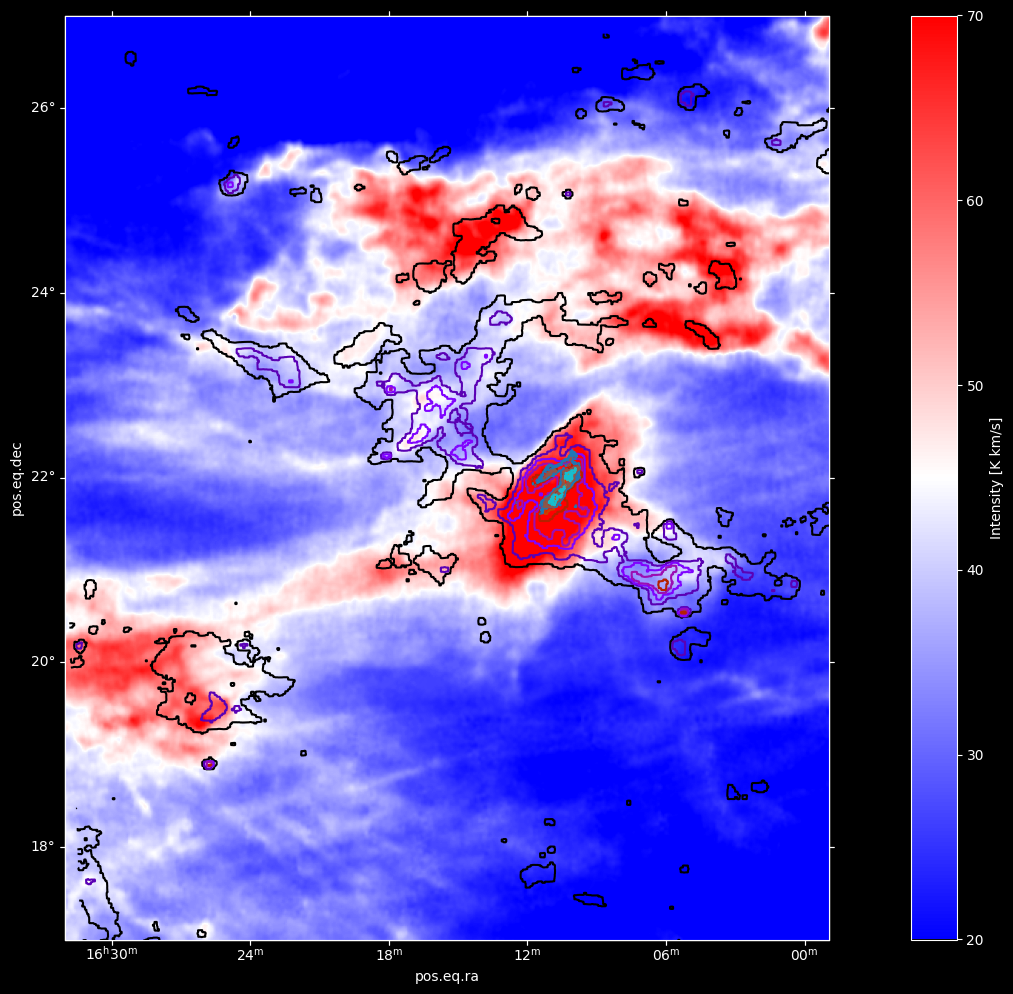

In [67]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111,projection=hi_m0.wcs)
img_hi = ax.imshow(hi_m0.hdu.data,cmap='bwr',vmin=20,vmax=70)
cbar_hi = plt.colorbar(img_hi,  fraction=0.046, pad=0.07)
cbar_hi.set_label('Intensity [K km/s]')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ir_transform = ax.get_transform(ir100_wcs)
levels = (4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5)
img_ir = ax.contour(ir100_data,cmap='gnuplot',levels=levels,transform=ir_transform)
co_transform = ax.get_transform(co_m0.wcs)
levels = (2,3,4)
img_co = ax.contour(co_m0.hdu.data,cmap='tab10',levels=levels,transform=co_transform)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

### Wider Window

In [ ]:
vel_range = (vel[0]*u_vel, vel[-1]*u_vel)
ra_range  = (248*u.deg,238*u.deg)
dec_range = (17*u.deg,24*u.deg)

cube1 : SpectralCube = SpectralCube.read(hi_paths[0]).with_spectral_unit(u_vel).subcube(*ra_range,*dec_range,*vel_range)
print(cube1)
header = cube1.header

hi_m01 = cube1.moment0()
del cube1


In [ ]:
dec_range = (22.6*u.deg,27*u.deg)
cube2 : SpectralCube = SpectralCube.read(hi_paths[1]).with_spectral_unit(u_vel).subcube(*ra_range,*dec_range,*vel_range)
print(cube2)
print(cube2.header.tostring(sep='\n'))

hi_m02 = cube2.moment0()


del cube2


In [ ]:
co_m0 = co_cube.moment0()
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=hi_m01.wcs)

print(hi_m01.hdu.data.min(),hi_m01.hdu.data.max())
img_hi = ax.imshow(hi_m01.hdu.data,cmap='viridis',origin='lower')
cbar_hi = plt.colorbar(img_hi, fraction=0.046)
cbar_hi.set_label('Intensity [K km/s]')
co_transform = ax.get_transform(co_m0.wcs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
levels = (2,3,4)
img_co = ax.contour(co_m0.hdu.data,cmap='viridis',levels=levels,transform=co_transform)
# cbar_hi = plt.colorbar(img_co, orientation='horizontal',  fraction=0.046, pad=0.07)
# cbar_hi.set_label('Intensity [K km/s]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [ ]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=hi_m01.wcs)

print(hi_m01.hdu.data.min(),hi_m02.hdu.data.max())
img_hi = ax.imshow(hi_m02.hdu.data,cmap='viridis',origin='lower',vmin=35,vmax=60)
cbar_hi = plt.colorbar(img_hi, fraction=0.046)
cbar_hi.set_label('Intensity [K km/s]')
co_transform = ax.get_transform(co_m0.wcs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
levels = (2,3,4)
img_co = ax.contour(co_m0.hdu.data,cmap='viridis',levels=levels,transform=co_transform)
# cbar_hi = plt.colorbar(img_co, orientation='horizontal',  fraction=0.046, pad=0.07)
# cbar_hi.set_label('Intensity [K km/s]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [ ]:
hi_data1 = hi_m01.hdu.data
hi_data2 = hi_m02.hdu.data
data = np.append(hi_data1[:-1],hi_data2,axis=0)
plt.figure(figsize=(17,10))
plt.imshow(data,origin='lower')
plt.show()

In [ ]:
vel_range = (vel[0]*u_vel, vel[-1]*u_vel)
ra_range  = (248*u.deg,238*u.deg)
dec_range = (17*u.deg,24*u.deg)

cube1 : SpectralCube = SpectralCube.read(hi_paths[0]).with_spectral_unit(u_vel).subcube(*ra_range,*dec_range,*vel_range)

data1 = cube1.hdu.data
head1 = cube1.header

_,dec1,_ = cube1.world[:]
print(dec1[0,-3:,0])

del cube1, dec1
